# Sarcasm Detection using the Pre-Trained BERT model from Transformers 

In [1]:
import numpy as np 
import pandas as pd 
import os



In [2]:

import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split


2023-05-03 17:58:50.728307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:58:50.864676: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-03 17:58:51.630594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-03 17:58:51.630667: W tensorflow/

In [3]:
data = pd.read_json("Sarcasm_Dataset.json", lines=True)
labels = data.is_sarcastic.values
sentences = data.headline.values
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


**Tokenizing all the sentences using pre-trained BERT model from Tranformers**

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

#split the dataset into Train and Test
train_sents,test_sents, train_labels, test_labels  = train_test_split(sentences,labels,test_size=0.15)

train_ids = encoder(train_sents)
test_ids = encoder(test_sents) 

/root/miniconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Converting arrays to tensors

In [5]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

2023-05-03 17:59:18.166297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:59:18.908956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22294 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:47:00.0, compute capability: 8.6


Building Model from transformers using pre-trained bert-base-uncased (12-layer, 768-hidden, 12-heads, 110M parameters.)

In [6]:
import tensorflow as tf
from transformers import TFBertModel

#MultiHeadAttention part
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, head_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.query_projection = tf.keras.layers.Dense(num_heads*head_dim, activation=None)
        self.key_projection = tf.keras.layers.Dense(num_heads*head_dim, activation=None)
        self.value_projection = tf.keras.layers.Dense(num_heads*head_dim, activation=None)
        self.output_projection = tf.keras.layers.Dense(head_dim, activation=None)

    def call(self, inputs, mask=None):
        batch_size = tf.shape(inputs)[0]
        query = self.query_projection(inputs)
        key = self.key_projection(inputs)
        value = self.value_projection(inputs)
        query = tf.reshape(query, [batch_size, -1, self.num_heads, self.head_dim])
        query = tf.transpose(query, [0, 2, 1, 3])
        key = tf.reshape(key, [batch_size, -1, self.num_heads, self.head_dim])
        key = tf.transpose(key, [0, 2, 1, 3])
        value = tf.reshape(value, [batch_size, -1, self.num_heads, self.head_dim])
        value = tf.transpose(value, [0, 2, 1, 3])
        scores = tf.matmul(query, key, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        if mask is not None:
            mask = tf.expand_dims(mask, 1)
            mask = tf.expand_dims(mask, 1)
            scores += (1.0 - mask) * -1e9
        attention_weights = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(attention_weights, value)
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, [batch_size, -1, self.num_heads*self.head_dim])
        outputs = self.output_projection(context)
        return outputs
    
#build the model
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")
embedding = bert_encoder([input_word_ids])
attention = MultiHeadAttention(num_heads=8, head_dim=64)(embedding[0])
cls_token = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(attention)
dense = tf.keras.layers.Dense(128, activation='relu')(cls_token)
dense = tf.keras.layers.Dropout(0.2)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=[input_word_ids], outputs=output)

2023-05-03 18:01:51.155995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions withou

In [7]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 16)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             16, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

Training

In [8]:
#training
history = model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))
#save weights
#model.save_weights('filename')  example:Bert_weights.h5

Epoch 1/3


2023-05-03 18:02:23.219449: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x557bea329dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-03 18:02:23.219474: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-03 18:02:23.238129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-03 18:02:23.477303: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1470/1470 [==============================] - 140s 66ms/step - loss: 0.2340 - accuracy: 0.9034 - val_loss: 0.1311 - val_accuracy: 0.9536
Epoch 2/3
1470/1470 [==============================] - 85s 58ms/step - loss: 0.0842 - accuracy: 0.9702 - val_loss: 0.1080 - val_accuracy: 0.9630
Epoch 3/3
1470/1470 [==============================] - 81s 55ms/step - loss: 0.0343 - accuracy: 0.9884 - val_loss: 0.0802 - val_accuracy: 0.9761


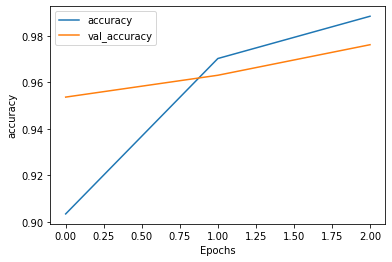

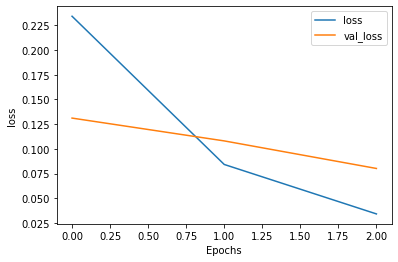

In [9]:
#draw the graph
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

260/260 [==============================] - 5s 18ms/step


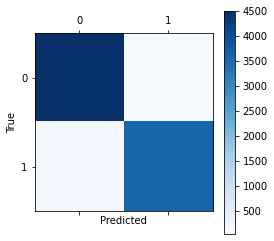

In [15]:
from sklearn.metrics import confusion_matrix

# 获取模型的预测结果
y_pred = model.predict(test_ids)
y_pred_labels = (y_pred > 0.5).astype(int)

# 计算并绘制混淆矩阵
cm = confusion_matrix(test_labels, y_pred_labels)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

260/260 [==============================] - 5s 18ms/step


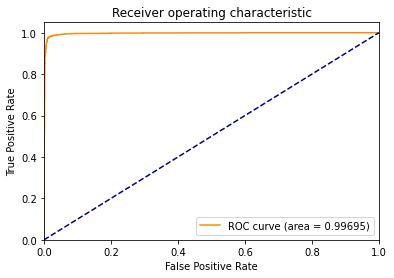

In [13]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 获取模型的预测结果
y_pred = model.predict(test_ids)

# 计算 FPR、TPR 和阈值
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)  # 计算 ROC 曲线下面积

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Manual test

In [10]:
#manual test
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Input the sentence you want to test 
sentence = "world's dumbest shoplifters literally run into the police at costco"

#translate sentence 
tokenized_sentence = tokenizer.encode(sentence, add_special_tokens=True)

maxlen = 16
padded_sentence = tf.keras.preprocessing.sequence.pad_sequences([tokenized_sentence], maxlen=maxlen, padding='post')

# model.load_weights('filename') example:Bert_weights.h5
# Could load the pretrained weights file or train by your self and test directly
prediction = model.predict(padded_sentence)

#show result
if prediction[0] > 0.5:
    print("This is a negative sentence.")
else:
    print("This is a positive sentence.")

1/1 [==============================] - 3s 3s/step
This is a positive sentence.
